# Fake News Detection Based on Hybrid Model (CNN & LSTM) and Simple RNN 
Simple Implementation based on the PDF documant in the repository.
you can find the material on this [link](https://www.sciencedirect.com/science/article/pii/S2667096820300070https://www.sciencedirect.com/science/article/pii/S2667096820300070)

In [1]:
import pandas as pd
import numpy as np

## Read Data

In [2]:
path = 'FA-KES.csv'
df = pd.read_csv(path, encoding= 'unicode_escape')
df.head()

,unit_id,article_title,article_content,source,date,location,labels
0,1914947530,Syria attack symptoms consistent with nerve ag...,Wed 05 Apr 2017 Syria attack symptoms consiste...,nna,4/5/2017,idlib,0
1,1914947532,Homs governor says U.S. attack caused deaths b...,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,nna,4/7/2017,homs,0
2,1914947533,Death toll from Aleppo bomb attack at least 112,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,nna,4/16/2017,aleppo,0
3,1914947534,Aleppo bomb blast kills six Syrian state TV,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,nna,4/19/2017,aleppo,0
4,1914947535,29 Syria Rebels Dead in Fighting for Key Alepp...,Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...,nna,7/10/2016,aleppo,0


In [3]:
X = df.drop('labels', axis=1)
y = df['labels']
X.shape, y.shape

((804, 6), (804,))

In [4]:
import tensorflow as tf
tf.__version__

'2.16.1'

## Preprocessing

In [5]:
content = X.copy()
content['article_content'][0]

'Wed 05 Apr 2017 Syria attack symptoms consistent with nerve agent use WHO. Victims of a suspected chemical attack in Syria appeared to show symptoms consistent with reaction to a nerve agent the World Health Organization said on Wednesday. "Some cases appear to show additional signs consistent with exposure to organophosphorus chemicals a category of chemicals that includes nerve agents" WHO said in a statement putting the death toll at at least 70. The United States has said the deaths were caused by sarin nerve gas dropped by Syrian aircraft. Russia has said it believes poison gas had leaked from a rebel chemical weapons depot struck by Syrian bombs. Sarin is an organophosporus compound and a nerve agent. Chlorine and mustard gas which are also believed to have been used in the past in Syria are not. A Russian Defence Ministry spokesman did not say what agent was used in the attack but said the rebels had used the same chemical weapons in Aleppo last year. The WHO said it was likely

In [6]:
content.reset_index(inplace=True)

In [7]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\parha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
# removing nonalphas and stopword
# lowering and stemming
# get vocabulary size and maximum length of atricles
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
vocab = []
max_length = 0
for i in range(len(content)):
    cln = re.sub('[^a-zA-Z]', ' ', content['article_content'][i])
    cln = cln.lower()
    cln = cln.split()
    vocab.extend(set(cln))
    if len(cln) > max_length:
        max_length = len(cln)
    cln = [ps.stem(word) for word in cln if not word in stopwords.words('english')]
    cln = ' '.join(cln)
    corpus.append(cln)
vocab = set(vocab)
vocab_size = len(vocab)

In [9]:
vocab_size, max_length

(9669, 1392)

In [10]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Dense
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, AveragePooling1D
from keras.layers import Dropout, GlobalMaxPooling1D, Flatten, BatchNormalization, GlobalAveragePooling1D
from keras.activations import relu, sigmoid
from tensorflow import keras

## Word Embedding

In [11]:
v_size = vocab_size
onehot_repr = [one_hot(words, v_size) for words in corpus] 
# onehot_repr

In [12]:
embedded_docs = pad_sequences(onehot_repr, padding='post', maxlen=300)
embedded_docs

array([[2435, 5464, 4652, ...,    0,    0,    0],
       [7300, 5464, 6719, ...,    0,    0,    0],
       [1864, 5464, 9532, ...,    0,    0,    0],
       ...,
       [ 462, 3095, 2874, ...,    0,    0,    0],
       [2874, 2526, 2886, ...,    0,    0,    0],
       [ 539, 8466, 9230, ...,    0,    0,    0]])

## Preparing Data

In [13]:
len(embedded_docs), y.shape

(804, (804,))

In [14]:
X_final = np.array(embedded_docs)
y_final = np.array(y)

In [15]:
len(embedded_docs), y.shape

(804, (804,))

In [16]:
from sklearn.model_selection import train_test_split
train_size=0.8
# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X_final, y_final, test_size=0.20, random_state=42)
# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.7
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=test_size, random_state=42)

## Creating Models 
   * __Hybrid(CNN&LSTM)__
   * __Hybrid(CNN&RNN)__
   * __Vanilla RNN__

## Hybrid (CNN & LSTM)

### Define the model architecture

In [17]:
## Creating model CNN_LSTM_Model
embedding_dim = 40
CNN_LSTM_Model = Sequential()
CNN_LSTM_Model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
CNN_LSTM_Model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
CNN_LSTM_Model.add(BatchNormalization())
# CNN_LSTM_Model.add(MaxPooling1D(pool_size=9))
CNN_LSTM_Model.add(AveragePooling1D(pool_size=9))
CNN_LSTM_Model.add(Dropout(0.3))
CNN_LSTM_Model.add(LSTM(units=100, return_sequences=True, activation='relu'))
CNN_LSTM_Model.add(Flatten())
CNN_LSTM_Model.add(BatchNormalization())
CNN_LSTM_Model.add(Dense(units=1, activation='sigmoid'))
CNN_LSTM_Model.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])
print(CNN_LSTM_Model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d (AveragePooling1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


### Training Model

In [18]:
### Finally Training
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
CNN_LSTM_Model_history = CNN_LSTM_Model.fit(x=X_train, y=y_train, validation_data=(X_valid, y_valid),
                     epochs=20,
                     verbose=2,
                     batch_size=64)

Epoch 1/20
11/11 - 4s - 395ms/step - accuracy: 0.5086 - loss: 0.7941 - val_accuracy: 0.5417 - val_loss: 0.6901
Epoch 2/20
11/11 - 1s - 64ms/step - accuracy: 0.6796 - loss: 0.5965 - val_accuracy: 0.5417 - val_loss: 0.6902
Epoch 3/20
11/11 - 1s - 63ms/step - accuracy: 0.8165 - loss: 0.4446 - val_accuracy: 0.5417 - val_loss: 0.6903
Epoch 4/20
11/11 - 1s - 63ms/step - accuracy: 0.8585 - loss: 0.3719 - val_accuracy: 0.5417 - val_loss: 0.6899
Epoch 5/20
11/11 - 1s - 62ms/step - accuracy: 0.9082 - loss: 0.2686 - val_accuracy: 0.5417 - val_loss: 0.6897
Epoch 6/20
11/11 - 1s - 63ms/step - accuracy: 0.9502 - loss: 0.1775 - val_accuracy: 0.5417 - val_loss: 0.6901
Epoch 7/20
11/11 - 1s - 63ms/step - accuracy: 0.9471 - loss: 0.1626 - val_accuracy: 0.5417 - val_loss: 0.6899
Epoch 8/20
11/11 - 1s - 62ms/step - accuracy: 0.9642 - loss: 0.1250 - val_accuracy: 0.5417 - val_loss: 0.6933
Epoch 9/20
11/11 - 1s - 64ms/step - accuracy: 0.9533 - loss: 0.1366 - val_accuracy: 0.5417 - val_loss: 0.7078
Epoch 10/

In [19]:
print(CNN_LSTM_Model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 300, 40)             │         386,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 298, 128)            │          15,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 298, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d (AveragePooling1D) │ (None, 33, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 33, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 33, 100)             │          91,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3300)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 3300)                │          13,200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           3,301 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,518,873 (5.79 MB)

 Trainable params: 504,005 (1.92 MB)

 Non-trainable params: 6,856 (26.78 KB)

 Optimizer params: 1,008,012 (3.85 MB)

None


### Visualization

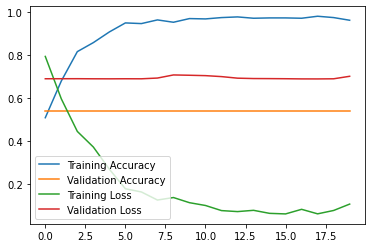

In [20]:
import matplotlib.pyplot as plt
plt.plot(CNN_LSTM_Model_history.history['accuracy'], label='Training Accuracy')
plt.plot(CNN_LSTM_Model_history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(CNN_LSTM_Model_history.history['loss'], label='Training Loss')
plt.plot(CNN_LSTM_Model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

### Testing

In [21]:
def scores(base_model, X_test, y_test, p=0.5):
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
    y_predict = base_model.predict(X_test)
    predicted_labels = (y_predict > p).astype(int)
    acc = accuracy_score(y_test, predicted_labels)
    prec = precision_score(y_test, predicted_labels)
    rec = recall_score(y_test, predicted_labels)
    f1 = f1_score(y_test, predicted_labels)
    print(f'accuracy: {acc}\t precision: {prec}\t recall: {rec}\t f1-score: {f1}')
    return acc, prec, rec, f1

In [22]:
acc, prec, rec, f1 = scores(base_model=CNN_LSTM_Model,
                           X_test=X_test,
                           y_test=y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
accuracy: 0.5575221238938053	 precision: 0.5575221238938053	 recall: 1.0	 f1-score: 0.7159090909090909


## Hybrid(CNN & simple RNN)

### Define the model architecture

In [23]:
# Hybrid(CNN & RNN)
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, SimpleRNN, Dense
embedding_dim = 40
# Define the model architecture
CNN_RNN_Model = Sequential()
CNN_RNN_Model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
CNN_RNN_Model.add(Conv1D(filters=16, kernel_size=5, activation='relu'))

CNN_RNN_Model.add(BatchNormalization())
# CNN_RNN_Model.add(Dropout(0.3))
CNN_RNN_Model.add(MaxPooling1D(pool_size=5))

CNN_RNN_Model.add(SimpleRNN(units=100, return_sequences=True))
CNN_RNN_Model.add(GlobalMaxPooling1D())
# CNN_RNN_Model.add(Flatten())
CNN_RNN_Model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
CNN_RNN_Model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
CNN_RNN_Model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [24]:
CNN_RNN_Model_history = CNN_RNN_Model.fit(x=X_train, y=y_train, epochs=10, 
                    validation_data=(X_valid, y_valid), 
                    verbose=2,
                    batch_size=64)

Epoch 1/10
11/11 - 3s - 288ms/step - accuracy: 0.4681 - loss: 0.7137 - val_accuracy: 0.5417 - val_loss: 0.6932
Epoch 2/10
11/11 - 0s - 27ms/step - accuracy: 0.8072 - loss: 0.5792 - val_accuracy: 0.5417 - val_loss: 0.6873
Epoch 3/10
11/11 - 0s - 25ms/step - accuracy: 0.9471 - loss: 0.4925 - val_accuracy: 0.5417 - val_loss: 0.6895
Epoch 4/10
11/11 - 0s - 25ms/step - accuracy: 0.9642 - loss: 0.4122 - val_accuracy: 0.5417 - val_loss: 0.6972
Epoch 5/10
11/11 - 0s - 25ms/step - accuracy: 0.9798 - loss: 0.3359 - val_accuracy: 0.5417 - val_loss: 0.7018
Epoch 6/10
11/11 - 0s - 25ms/step - accuracy: 0.9782 - loss: 0.2719 - val_accuracy: 0.5417 - val_loss: 0.7121
Epoch 7/10
11/11 - 0s - 26ms/step - accuracy: 0.9767 - loss: 0.2511 - val_accuracy: 0.5417 - val_loss: 0.7155
Epoch 8/10
11/11 - 0s - 25ms/step - accuracy: 0.9751 - loss: 0.2281 - val_accuracy: 0.5417 - val_loss: 0.6916
Epoch 9/10
11/11 - 0s - 26ms/step - accuracy: 0.9798 - loss: 0.1963 - val_accuracy: 0.5417 - val_loss: 0.7113
Epoch 10/

### Visualization

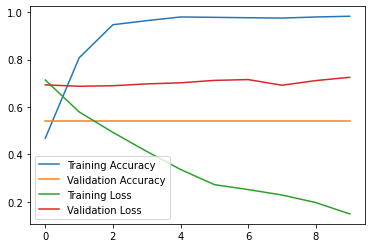

In [25]:
import matplotlib.pyplot as plt
plt.plot(CNN_RNN_Model_history.history['accuracy'], label='Training Accuracy')
plt.plot(CNN_RNN_Model_history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(CNN_RNN_Model_history.history['loss'], label='Training Loss')
plt.plot(CNN_RNN_Model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

### Testing

In [26]:
acc, prec, rec, f1 = scores(base_model=CNN_RNN_Model,
                           X_test=X_test,
                           y_test=y_test) 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
accuracy: 0.5575221238938053	 precision: 0.5575221238938053	 recall: 1.0	 f1-score: 0.7159090909090909


In [27]:
CNN_RNN_Model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 300, 40)             │         386,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 296, 16)             │           3,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 296, 16)             │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 59, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 59, 100)             │          11,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 100)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,205,461 (4.60 MB)

 Trainable params: 401,809 (1.53 MB)

 Non-trainable params: 32 (128.00 B)

 Optimizer params: 803,620 (3.07 MB)

## RNN (LSTM)

### Define the model architecture

In [28]:
## Creating model LSTM_Model
embedding_dim = 40
LSTM_Model = Sequential()
LSTM_Model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
LSTM_Model.add(LSTM(units=100, return_sequences=True, activation='relu'))
LSTM_Model.add(BatchNormalization())
LSTM_Model.add(Flatten())
LSTM_Model.add(Dense(units=1, activation='sigmoid'))
LSTM_Model.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])
print(LSTM_Model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


### Training Model

In [29]:
### Finally Training
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
LSTM_Model_history = LSTM_Model.fit(x=X_train, y=y_train, validation_data=(X_valid, y_valid),
                     epochs=10,
                     verbose=2,
                     batch_size=64)

Epoch 1/10
11/11 - 5s - 470ms/step - accuracy: 0.5381 - loss: 0.7211 - val_accuracy: 0.5417 - val_loss: 0.6911
Epoch 2/10
11/11 - 3s - 231ms/step - accuracy: 0.7589 - loss: 0.5994 - val_accuracy: 0.5417 - val_loss: 0.6909
Epoch 3/10
11/11 - 2s - 226ms/step - accuracy: 0.8569 - loss: 0.4757 - val_accuracy: 0.5417 - val_loss: 0.6896
Epoch 4/10
11/11 - 2s - 217ms/step - accuracy: 0.9005 - loss: 0.3320 - val_accuracy: 0.5417 - val_loss: 0.6900
Epoch 5/10
11/11 - 2s - 214ms/step - accuracy: 0.9331 - loss: 0.2159 - val_accuracy: 0.5208 - val_loss: 0.6893
Epoch 6/10
11/11 - 2s - 213ms/step - accuracy: 0.9596 - loss: 0.1299 - val_accuracy: 0.5417 - val_loss: 0.6914
Epoch 7/10
11/11 - 2s - 215ms/step - accuracy: 0.9565 - loss: 0.1105 - val_accuracy: 0.5417 - val_loss: 0.6940
Epoch 8/10
11/11 - 3s - 232ms/step - accuracy: 0.9673 - loss: 0.1206 - val_accuracy: 0.5208 - val_loss: 0.6916
Epoch 9/10
11/11 - 2s - 211ms/step - accuracy: 0.9798 - loss: 0.1253 - val_accuracy: 0.4583 - val_loss: 0.6952
E

In [30]:
print(LSTM_Model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 300, 40)             │         386,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 300, 100)            │          56,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 300, 100)            │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │          30,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,420,285 (5.42 MB)

 Trainable params: 473,361 (1.81 MB)

 Non-trainable params: 200 (800.00 B)

 Optimizer params: 946,724 (3.61 MB)

None


### Visualization

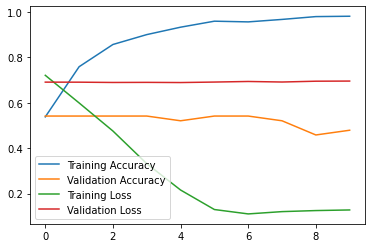

In [31]:
import matplotlib.pyplot as plt
plt.plot(LSTM_Model_history.history['accuracy'], label='Training Accuracy')
plt.plot(LSTM_Model_history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(LSTM_Model_history.history['loss'], label='Training Loss')
plt.plot(LSTM_Model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

### Testing

In [32]:
acc, prec, rec, f1 = scores(base_model=LSTM_Model,
                           X_test=X_test,
                           y_test=y_test)

2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step WARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001B768256CB0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
accuracy: 0.5309734513274337	 precision: 0.6190476190476191	 recall: 0.4126984126984127	 f1-score: 0.49523809523809526
